## Interpolating HEALPix GRIB fields

This example shows how to interpolate GRIB data defined on a HEALPix nested grid. We will aslo see how to inspect and plot the resulting data and how to convert it to xarray.

To make this notebook work **earthkit.data** and **earthkit.maps** have to be installed. The data will be represented as an [earthkit-data GRIB FieldList](https://earthkit-data.readthedocs.io/en/latest/guide/data_format/grib.html).

In [1]:
from earthkit.regrid import interpolate
from earthkit.data import from_source, FieldList

# Get HEALPix nested GRIB data containing two fields.
ds = from_source(
    "url", 
    "https://get.ecmwf.int/repository/test-data/earthkit-regrid/examples/H8_nested_multi.grib2")

# the target grid is a global 5x5 degree regular latitude grid
target_gridspec = {"grid": [5,5]}

r = FieldList()
for f in ds:
    v_res = interpolate(f.to_numpy(flatten=True), f.metadata().gridspec, target_gridspec,
                       method="linear")
    md_res = f.metadata().override(gridspec=target_gridspec)
    r += ds.from_numpy(v_res, md_res)

d = r.data()
lat = d[0]
lon = d[1]
vals = d[2:]
lat.shape, lon.shape, vals.shape

((37, 72), (37, 72), (2, 37, 72))

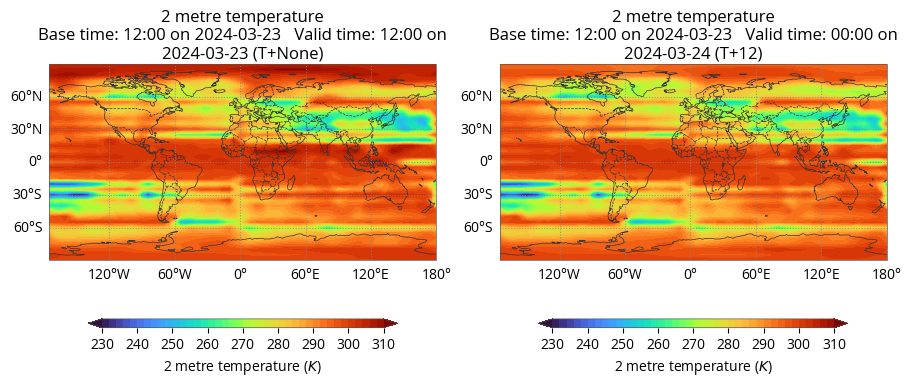

In [2]:
import earthkit.maps
earthkit.maps.quickplot(r)

In [3]:
r.to_xarray()

<xarray.Dataset>
Dimensions:            (time: 1, step: 2, heightAboveGround: 1, latitude: 37,
                        longitude: 72)
Coordinates:
  * time               (time) datetime64[ns] 2024-03-23T12:00:00
  * step               (step) timedelta64[ns] 00:00:00 12:00:00
  * heightAboveGround  (heightAboveGround) float64 2.0
  * latitude           (latitude) float64 90.0 85.0 80.0 ... -80.0 -85.0 -90.0
  * longitude          (longitude) float64 0.0 5.0 10.0 ... 345.0 350.0 355.0
    valid_time         (time, step) datetime64[ns] ...
Data variables:
    t2m                (time, step, heightAboveGround, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            2
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-03-25T09:17 GRIB to CDM+CF via cfgrib-0.9.1...